## Setup

In [1]:
%run setup.ipynb

# %matplotlib notebook
# %reload_ext autoreload
# %autoreload 1
# %aimport hapclust
import hapclust

In [3]:
# obtain data from unphased callset - only needed for variant annotations
callset_pass = phase1_ar31.callset_pass
pos_pass = allel.SortedIndex(callset_pass['2L/variants/POS'])
ann_pass = callset_pass['2L/variants/ANN'][:][['Annotation', 'HGVS_p']]

In [4]:
# setup haplotype data
callset_phased = phase1_ar31.callset_phased
genotypes_phased = allel.GenotypeDaskArray(callset_phased['2L/calldata/genotype'])
pos_phased = allel.SortedIndex(callset_phased['2L/variants/POS'])

In [5]:
pos_kdr_s = 2422651
pos_kdr_f = 2422652

In [6]:
# define region we're going to analyse
loc_region = pos_phased.locate_range(0, 4000000)
pos_phased_region = pos_phased[loc_region]
pos_phased_region

0,1,2,3,4,...,163958,163959,163960,163961,163962
44688,44691,44732,44736,44756,...,3997372,3997373,3997378,3997381,3997386


In [7]:
# locate the intersection with unphased callset - needed to tie in annotations
loc1, _ = pos_pass.locate_intersection(pos_phased_region)
np.count_nonzero(loc1)

163963

In [8]:
ann_phased_region = ann_pass[loc1]
collections.Counter(ann_phased_region['Annotation'])

Counter({b'3_prime_UTR_variant': 2941,
         b'5_prime_UTR_premature_start_codon_': 306,
         b'5_prime_UTR_variant': 1677,
         b'downstream_gene_variant': 18539,
         b'initiator_codon_variant': 3,
         b'intergenic_region': 54849,
         b'intragenic_variant': 48,
         b'intron_variant': 32362,
         b'missense_variant': 5805,
         b'missense_variant&splice_region_var': 70,
         b'splice_acceptor_variant&intron_var': 24,
         b'splice_donor_variant&intron_varian': 27,
         b'splice_region_variant': 36,
         b'splice_region_variant&intron_varia': 649,
         b'splice_region_variant&stop_retaine': 5,
         b'splice_region_variant&synonymous_v': 87,
         b'start_lost': 9,
         b'stop_gained': 37,
         b'stop_lost&splice_region_variant': 4,
         b'stop_retained_variant': 5,
         b'synonymous_variant': 8636,
         b'upstream_gene_variant': 37844})

In [9]:
# exclude cross parents
haps_phased_region = genotypes_phased[loc_region].to_haplotypes()[:, :-16].compute()

In [10]:
# perform allele count - needed to locate singletons
ac_phased_region = haps_phased_region.count_alleles(max_allele=1)

In [11]:
# define types of variants to include in EHH analysis - should be mostly neutral
loc_type_neutral = ((ann_phased_region['Annotation'] == b'intergenic_region') | 
                    (ann_phased_region['Annotation'] == b'intron_variant') |
                    (ann_phased_region['Annotation'] == b'downstream_gene_variant') |
                    (ann_phased_region['Annotation'] == b'upstream_gene_variant') |
                    (ann_phased_region['Annotation'] == b'synonymous_variant') |
                    (ann_phased_region['Annotation'] == b'3_prime_UTR_variant') |
                    (ann_phased_region['Annotation'] == b'5_prime_UTR_variant') 
                    )
np.count_nonzero(loc_type_neutral), loc_type_neutral.shape

(156848, (163963,))

In [12]:
haps_neutral = haps_phased_region[loc_type_neutral]
pos_neutral = pos_phased_region[loc_type_neutral]

In [13]:
# read in haplotype metadata to get population
df_haplotypes = phase1_ar31.df_haplotypes
df_haplotypes = df_haplotypes[df_haplotypes.population != 'colony']
df_haplotypes.head()

,label,ox_code,population,label_aug,country,region,sex,m_s,kt_2la,kt_2rb
index,,,,,,,,,,
0,AB0085-Ca,AB0085-C,BFS,"AB0085-Ca [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
1,AB0085-Cb,AB0085-C,BFS,"AB0085-Cb [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
2,AB0087-Ca,AB0087-C,BFM,"AB0087-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
3,AB0087-Cb,AB0087-C,BFM,"AB0087-Cb [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
4,AB0088-Ca,AB0088-C,BFM,"AB0088-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,0.0


In [14]:
core_pos = pos_kdr_f

In [15]:
# split the dataset into flanks
dist_right, dist_left, haps_right, haps_left = hapclust.split_flanks(
    haps_phased_region, pos_phased_region, core_pos
)

In [16]:
# split the dataset (neutral variants only) into flanks
dist_neutral_right, dist_neutral_left, haps_neutral_right, haps_neutral_left = hapclust.split_flanks(
    haps_neutral, pos_neutral, core_pos
)

In [17]:
haps_right

<HaplotypeArray shape=(137962, 1530) dtype=int8>
1 1 0 1 1 ... 1 1 1 1 1
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [18]:
haps_neutral_right

<HaplotypeArray shape=(131569, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [19]:
haps_left

<HaplotypeArray shape=(26001, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [20]:
haps_neutral_left

<HaplotypeArray shape=(25279, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [21]:
def hl(n, randomize=True, seed=None):

    breaks = hapclust.locate_breakpoints_by_4gametes(hs[:, :n], randomize=randomize, seed=seed)
    print(breaks)

    # fix non-breaks
    breaks[breaks == hs.shape[0]] = hs.shape[0] - 1

    # compute pairwise shared length
    psl = np.zeros((n, n))
    
    breaks_pdist = np.zeros((n, n), dtype=int)
    for i, j in itertools.combinations(range(n), 2):
        d = min(breaks_dist[[i, j]])
        breaks_pdist[i, j] = d
        breaks_pdist[j, i] = d

    breaks_pdist_cond = scipy.spatial.distance.squareform(breaks_pdist)

    return breaks_pdist_cond


## Legacy

In [1]:
%run setup.ipynb

%matplotlib notebook
%reload_ext autoreload
%autoreload 1
%aimport hapclust
# import hapclust

In [2]:
callset_phased = phase1_ar31.callset_phased
genotypes_phased = allel.GenotypeDaskArray(callset_phased['2L/calldata/genotype'])
pos_phased = allel.SortedIndex(callset_phased['2L/variants/POS'])

In [3]:
pos_kdr_s = 2422651
pos_kdr_f = 2422652

In [4]:
# define region we're going to analyse
loc_region = pos_phased.locate_range(0, 4000000)
pos_phased_region = pos_phased[loc_region]
pos_phased_region

0,1,2,3,4,...,163958,163959,163960,163961,163962
44688,44691,44732,44736,44756,...,3997372,3997373,3997378,3997381,3997386


In [5]:
df_haplotypes = phase1_ar31.df_haplotypes
df_haplotypes = df_haplotypes[df_haplotypes.population != 'colony']
df_haplotypes.head()

,label,ox_code,population,label_aug,country,region,sex,m_s,kt_2la,kt_2rb
index,,,,,,,,,,
0,AB0085-Ca,AB0085-C,BFS,"AB0085-Ca [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
1,AB0085-Cb,AB0085-C,BFS,"AB0085-Cb [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
2,AB0087-Ca,AB0087-C,BFM,"AB0087-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
3,AB0087-Cb,AB0087-C,BFM,"AB0087-Cb [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
4,AB0088-Ca,AB0088-C,BFM,"AB0088-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,0.0


In [6]:
core_pos = pos_kdr_f

In [7]:
haps_region = genotypes_phased[loc_region].to_haplotypes()[:, :-16].compute()
haps_region

<HaplotypeArray shape=(163963, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [8]:
# split the dataset
dist_right, dist_left, haps_right, haps_left = hapclust.split_flanks(
    haps_region, pos_phased_region, core_pos
)

In [9]:
dist_right

array([      0,      45,      82, ..., 1574726, 1574729, 1574734], dtype=int32)

In [10]:
haps_right

<HaplotypeArray shape=(137962, 1530) dtype=int8>
1 1 0 1 1 ... 1 1 1 1 1
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [11]:
haps_left

<HaplotypeArray shape=(26001, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

## Sandbox

In [12]:
h = haps_right

In [13]:
h.shape

(137962, 1530)

In [125]:
%time hapclust.locate_breakpoints_by_4gametes(h[:2000, :], seed=1)

CPU times: user 180 ms, sys: 0 ns, total: 180 ms
Wall time: 181 ms


array([1743, 2000,  784, ..., 2000, 1743, 2000])

In [126]:
%timeit hapclust.locate_breakpoints_by_4gametes(h[:2000, :], seed=1)

138 ms ± 3.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
%timeit hapclust.locate_breakpoints_by_4gametes(h[:2000, :], seed=1)

141 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [127]:
%time hapclust.locate_breakpoints_by_4gametes(h[:, :], seed=1)

CPU times: user 3.98 s, sys: 0 ns, total: 3.98 s
Wall time: 3.97 s


array([ 1743, 14218,   784, ...,  4801,  1743,  4326])

In [47]:
%time hapclust.locate_breakpoints_by_4gametes(h[:, :], seed=1)

CPU times: user 4.02 s, sys: 0 ns, total: 4.02 s
Wall time: 4.02 s


array([ 1743, 14218,   784, ...,  4801,  1743,  4326])

In [49]:
a = set(np.random.randint(1, 10000, 10000))
b = set(np.random.randint(1, 10000, 1000))
print(len(a), len(b))
%timeit a.intersection(b)
%timeit b.intersection(a)

6324 952
44.4 µs ± 550 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
44 µs ± 163 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [32]:
a = set(np.random.randint(1, 10000, 1000))
%timeit len(a)

57.4 ns ± 0.561 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [52]:
a = np.unique(np.random.randint(1, 10000, 10000))
b = np.unique(np.random.randint(1, 10000, 1000))
%timeit np.intersect1d(b, a, assume_unique=True)

148 µs ± 2.88 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [63]:
a = np.zeros(10000, dtype=bool)
a[np.random.randint(1, 10000, 10000)] = True
b = np.zeros(10000, dtype=bool)
b[np.random.randint(1, 10000, 1000)] = True

%timeit a & b

1.02 µs ± 11.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [87]:
a = np.zeros(10000, dtype=bool)
a[np.random.randint(1, 10000, 10000)] = True
b = np.zeros(10000, dtype=bool)
b[np.random.randint(1, 10000, 1000)] = True

%timeit np.logical_and(a, b, )

1.04 µs ± 13.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [123]:
%timeit np.count_nonzero(a)

756 ns ± 4.45 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [122]:
%timeit a.sum()

10 µs ± 53.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [117]:
%%cython -a
# cython: boundscheck=False
# cython: wraparound=False


import numpy as np
cimport numpy as np


def myany(np.uint8_t[:] a):
    cdef:
        int i, n
        np.uint8_t* data = &a[0]
    n = a.shape[0]
    for i in range(n):
        if data[i] != 0:
            return True
    return False
    
    
def mynnz(np.uint8_t[:] a):
    cdef:
        int i, n, c
        np.uint8_t* data = &a[0]
    c = 0
    n = a.shape[0]
    for i in range(n):
        if data[i] != 0:
            c += 1
    return c
        

In [89]:
%timeit np.any(a)

2.6 µs ± 125 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [116]:
b = a.view('u1')
%timeit myany(b)

384 ns ± 3.19 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [118]:
b = a.view('u1')
%timeit mynnz(b)

6.35 µs ± 60.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [65]:
a = np.zeros(10000, dtype=bool)
a[np.random.randint(1, 10000, 1000)] = True
b = np.zeros(10000, dtype=bool)
b[np.random.randint(1, 10000, 1000)] = True
a = np.packbits(a)
b = np.packbits(b)

In [66]:
%timeit np.bitwise_and(a, b)

686 ns ± 5.77 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [68]:
np.unpackbits(a).shape

(10000,)

In [69]:
np.packbits([0, 1, 0])

array([64], dtype=uint8)

In [72]:
np.unpackbits(np.array([64], dtype='uint8'))

array([0, 1, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [46]:
a = b'012'
b = b'121'

In [47]:
a | b

TypeError: unsupported operand type(s) for |: 'bytes' and 'bytes'

In [ ]:
%timeit 

In [29]:
np.count_nonzero(a & b)

88

In [26]:
%time hapclust.locate_breakpoints_by_4gametes_opt(h[:, :], seed=1)

KeyboardInterrupt: 

In [24]:
from hapclust import locate_breakpoints_by_4gametes

In [25]:
import line_profiler
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [77]:
%lprun -f locate_breakpoints_by_4gametes locate_breakpoints_by_4gametes(h[:5000, :])

In [21]:
%lprun -f locate_breakpoints_by_4gametes_opt locate_breakpoints_by_4gametes_opt(h[:100, :1000])

foo


In [21]:
random.seed(42)

import random
random.choice([1, 2])

1

In [48]:
hs = h[:, h.prefix_argsort()]

In [57]:
def spike_breaks(n, randomize=True, seed=None):

    breaks = hapclust.locate_breakpoints_by_4gametes(hs[:, :n], randomize=randomize, seed=seed)
#     print(breaks)

    breaks[breaks == hs.shape[0]] = hs.shape[0] - 1
    breaks_dist = dist_right[breaks]

    breaks_pdist = np.zeros((n, n), dtype=int)
    for i, j in itertools.combinations(range(n), 2):
        d = min(breaks_dist[[i, j]])
        breaks_pdist[i, j] = d
        breaks_pdist[j, i] = d

    breaks_pdist_cond = scipy.spatial.distance.squareform(breaks_pdist)

    return breaks_pdist_cond


In [58]:
x1 = spike_breaks(100, randomize=False)

<IPython.core.display.Javascript object>


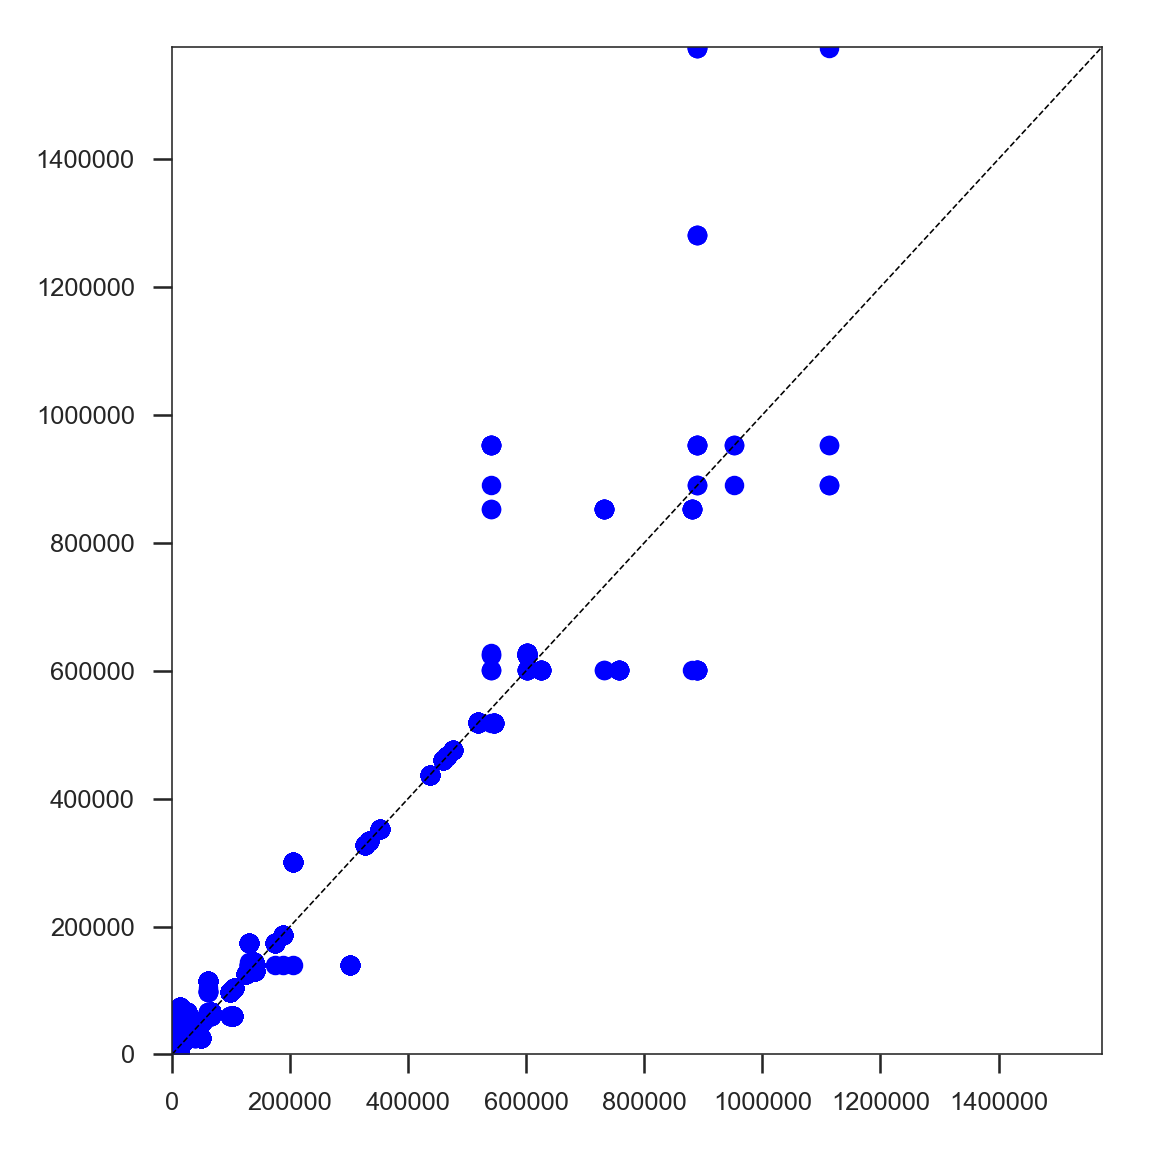

In [61]:
x2 = spike_breaks(100, randomize=True)

plt.figure(figsize=(5, 5))
plt.plot(x1, x2, 'bo')
vmax = max(x1.max(), x2.max())
plt.ylim(0, vmax)
plt.xlim(0, vmax)
plt.plot([0, vmax], [0, vmax], 'k--')
plt.tight_layout();

<IPython.core.display.Javascript object>


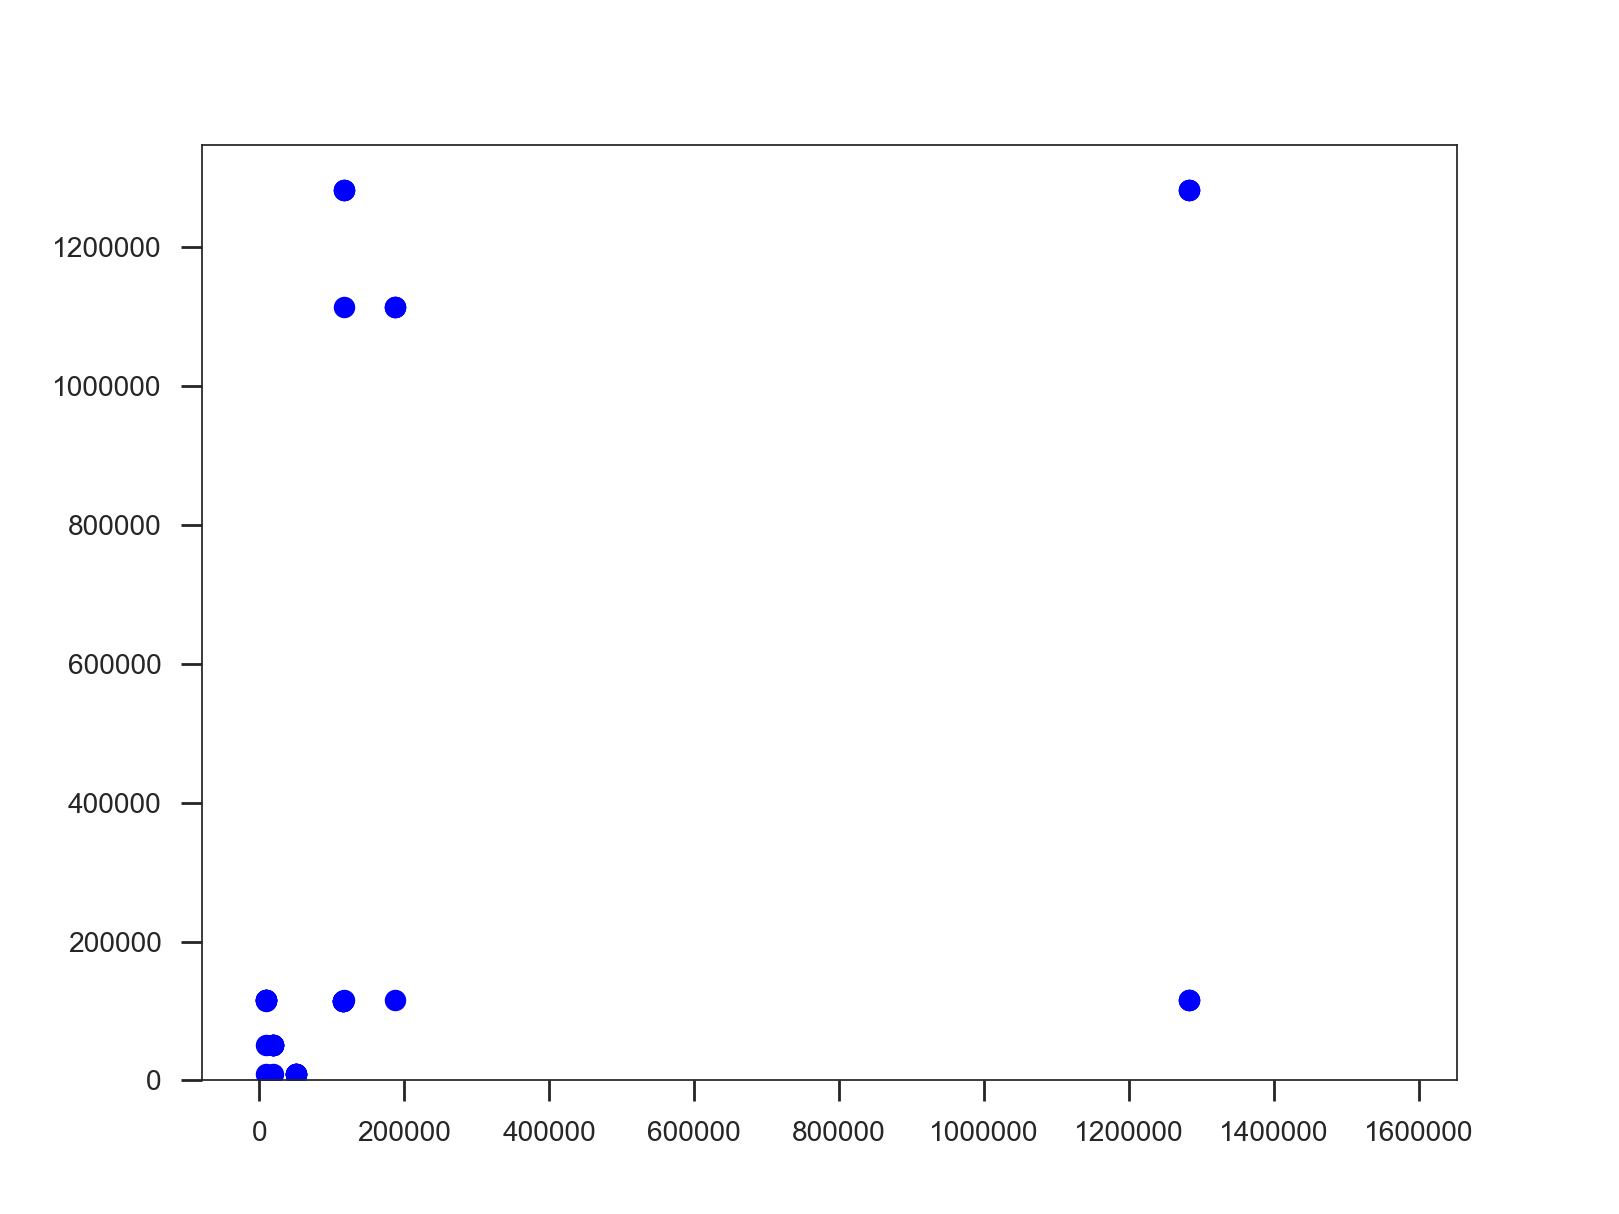

In [105]:
plt.hist(breaks_pdist_cond, bins=np.linspace(0, dist_right.max(), 50));

In [40]:
%time hapclust.locate_breakpoints_by_4gametes(h[:, :])

CPU times: user 10.7 s, sys: 28 ms, total: 10.7 s
Wall time: 10.7 s


array([ 1706, 14218,   784, ...,  4801,  1706,  4326])

In [20]:
dist_right[78716]

1176829

In [136]:
locate_recombination_by_splits_flank(h[:, :20])

single split, splitting cluster 0
iteration 010 minor allele 1 mac 9 haps [0 0 1 0 0 0 1 0 1 1 1 0 1 1 1 0 0 0 1 0] clusters [0 0 1 0 0 0 1 0 1 1 1 0 1 1 1 0 0 0 1 0] breakpoints [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
single split, splitting cluster 1
iteration 4255 minor allele 1 mac 8 haps [0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0] clusters [0 0 2 0 0 0 2 0 2 2 1 0 2 2 2 0 0 0 2 0] breakpoints [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
multiple splits, recombination detected
iteration 4313 minor allele 1 mac 9 haps [0 0 1 0 0 0 1 0 1 1 1 0 1 1 1 0 0 0 1 0] clusters [0 0 2 0 0 0 2 0 2 2 1 0 2 2 2 0 0 0 2 0] breakpoints [   0    0    0    0    0    0    0    0    0    0 4313    0    0    0    0
    0    0    0    0    0]
single split, splitting cluster 2
iteration 6362 minor allele 1 mac 8 haps [0 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 0 1 0] clusters [0 0 3 0 0 0 3 0 3 2 1 0 3 3 3 0 0 0 3 0] breakpoints [   0    0    0    0    0    0    0    0    0    0 4313    0    0    0    0
    0    0  

In [132]:
dist_right[68045]

1077495

In [133]:
np.argmax?

In [77]:
def locate_recombination(h):
    ac = h.count_alleles()
    splits = [set(range(h.shape[1]))]
    for i in range(h.shape[0]):
        minor_allele = ac[i].argmin()
        minor_allele_count = ac[i, minor_allele]
        log('iteration', i, 'minor allele', minor_allele, 'mac', minor_allele_count)
        if minor_allele_count > 1:
            split = set(np.nonzero(h[i] == minor_allele)[0])
            log('split', split)
        

In [80]:
x = set([1, 2, 3])

In [82]:
x.issubset(set([1, 2, 4]))

False

In [78]:
locate_recombination(hseg[:10])

iteration 0 minor allele 1 mac 4
split {8, 9, 2, 6}
iteration 1 minor allele 0 mac 4
split {8, 9, 2, 6}
iteration 2 minor allele 1 mac 4
split {8, 9, 2, 6}
iteration 3 minor allele 1 mac 4
split {8, 9, 2, 6}
iteration 4 minor allele 0 mac 4
split {8, 9, 2, 6}
iteration 5 minor allele 1 mac 4
split {8, 9, 2, 6}
iteration 6 minor allele 0 mac 4
split {8, 9, 2, 6}
iteration 7 minor allele 1 mac 4
split {8, 9, 2, 6}
iteration 8 minor allele 1 mac 4
split {8, 9, 2, 6}
iteration 9 minor allele 0 mac 4
split {8, 9, 2, 6}


In [65]:
# def locate_breakpoints(h):
#     # take a copy
#     h = np.array(h, dtype='i1')
#     # iterate away from core
#     for i in range(2, h.shape[0]):
# #         log('iteration', i)
#         hf = h[:i]
#         recombinants = hapclust.locate_recombinants(hf)[0]
#         if recombinants:
#             nonrec = [i for i in range(h.shape[1]) if i not in recombinants]
#             h = h[:, nonrec]
#             log('variant %s; found recombinant: %r; haps remaining: %s' % (i, recombinants, h.shape[1]))


In [66]:
locate_breakpoints(hseg[:1000])

variant 356; found recombinant: {9}; haps remaining: 9


KeyboardInterrupt: 

In [53]:
hseg[:40, [0, 1, 3, 4]].displayall()

,0,1,2,3
0,1,1,0,1
1,1,1,0,1
2,1,0,1,1
3,1,1,1,0
4,1,1,0,1
5,1,0,1,1
6,0,1,1,0
7,1,0,1,1
8,1,1,1,0
9,1,1,0,1
